<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Bootstrap

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy* [e-book]. Zenodo. doi:10.5281/zenodo.15169133 [![DOI](https://zenodo.org/badge/838927017.svg)](https://doi.org/10.5281/zenodo.15169132)  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository* (0.0.1) [Software]. Zenodo. doi:10.5281/zenodo.12667036. GitHub Repository: https://github.com/GeostatsGuy/GeostatsPyDemos [![DOI](https://zenodo.org/badge/777871341.svg)](https://doi.org/10.5281/zenodo.12667035)



```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Bootstrap**. 

**YouTube Lecture**: check out my lecture on [Bootstrap](https://youtu.be/wCgdoImlLY0?si=lpTWz2H7QTdxHBy9). For your convenience here's a summary of salient points.

#### Bootstrap

Bootstrap is a statistical resampling procedure to calculate uncertainty in a calculated statistic from the sample data itself. Some general comments,

* **sampling with replacement** - $n$ (number of data samples) Monte Carlo simulations from the dataset cumulative distribution function, this results in a new realization of the data

* **simulates the data collection process** - the fundamental idea is to simulate the original data collection process. Instead of actually collecting new sample sets (this would be infeasible), we randomly select from the data to get data realizations
  
* **bootstrap any statistic** - this approach is very flexible as we can calculate realizations of any statistics from the data realizations

* **computationally cheap** - repeat this approach to get realizations of the statistic to build a complete distribution of uncertainty. Use a large number of realizations, $L$, for a reliable uncertainty model.

* **calculates the entire distribution of uncertainty** - for any statistic, you calculate any summary statistic for the uncertainty model, e.g., mean, P10 and P90 of the uncertainty in the mean

* **bagging for machine learning** - is the application with bootstrap to obtain data realizations to train predictive model realizations to aggregate predictions over ensembles of prediction models to reduce model variance

What are the limitations of bootstrap?

* biased sample data will likely result in a biased bootstrapped uncertainty model, you must first debias the samples, e.g., declustering

* you must have a sufficient sample size

* integrates uncertainty due to sparse samples in space only, does not account for uncertainty due sampling error and sample bias.

* assumes independence between samples and does not account for the spatial context of the data, i.e., sample data locations, volume of interest nor the spatial continuity. There is a variant of bootstrap called [spatial bootstrap](https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Spatial_Bootstrap.ipynb). 

#### Boostrap Philosophy

The general bootstrap approach developed by Efron (1979) is an attempt to simulate the sampling process to access the uncertainty due to the limited sample data.

* We could access this by existing over multiple parallel universes, in each we collect $n$ different datasets. Then we could perform our operations, including calculating sample statistics and building predictive models.

* The realizations of the sample statistics or model predictions can be pooled, assumed to be equiprobable, and the resulting distribution treated as an uncertainty model.

What's the problem with this? We don't exist over parallel universes. 

* Could we just calculate multiple exclusive datasets of $n$ samples? No. Given the typical cost and value of samples, this would not be a practical workflow.

Efron suggested that instead we sample from the available data with replacement. 

* Efron is simulating the sampling process from the sample itself!

Let's load a dataset and look at it.

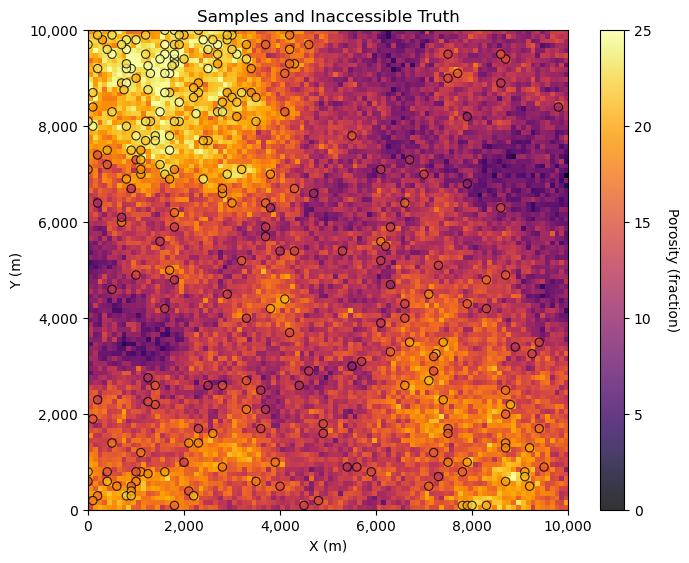

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker                            # custom axes
import geostatspy.GSLIB as GSLIB
cmap = plt.cm.inferno
formatter = ticker.FuncFormatter(lambda x, _: f'{x:,.0f}')

xmin = 0.0; xmax = 10000.0; ymin = 0.0; ymax = 10000.0; csize = 100; pormin = 0; pormax = 25

por_sample = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v5_sand_only.csv')
por_truth = np.loadtxt('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/refs/heads/master/spatial_nonlinear_MV_facies_v5_sand_only_truth_por.csv', delimiter=',')

#GSLIB.locmap_st(por_sample,'X','Y','Por',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
GSLIB.locpix_st(por_truth,xmin,xmax,ymin,ymax,csize,pormin,pormax,por_sample,'X','Y','Por','Samples and Inaccessible Truth','X (m)','Y (m)','Porosity (fraction)',cmap)
plt.gca().xaxis.set_major_formatter(formatter); plt.gca().yaxis.set_major_formatter(formatter)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

We can see the inaccessible truth and the samples. Now, let's demonstrate 4 dataset realizations from the truth model.

* while this is not practical, it is instructive to visualize this

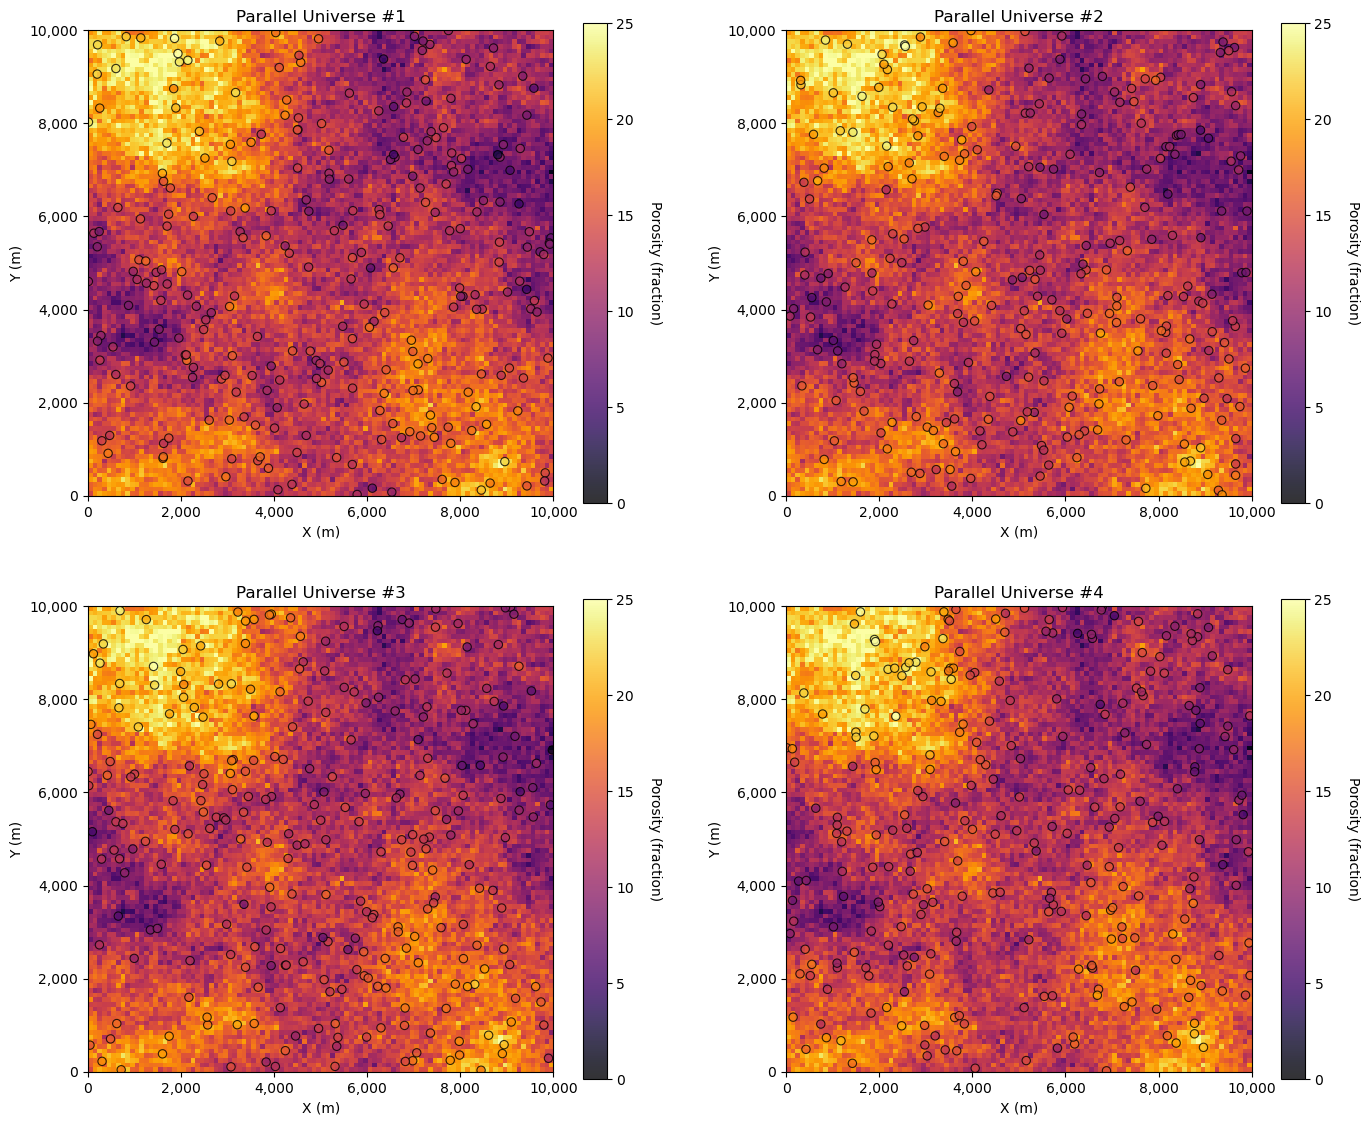

In [2]:
L = 4
for l in range(0,L):
    x_rel = np.random.uniform(xmin,xmax,len(por_sample)); y_rel = np.random.uniform(ymin,ymax,len(por_sample))
    df_temp = pd.DataFrame({'x_rel': x_rel,'y_rel': y_rel})
    df_temp = GSLIB.sample(por_truth,xmin,ymin,csize,'por_real',df_temp,'x_rel','y_rel')

    plt.subplot(2,2,l+1)
    GSLIB.locpix_st(por_truth,xmin,xmax,ymin,ymax,csize,pormin,pormax,df_temp,'x_rel','y_rel','por_real','Parallel Universe #' + str(l+1),'X (m)','Y (m)','Porosity (fraction)',cmap)
    plt.gca().xaxis.set_major_formatter(formatter); plt.gca().yaxis.set_major_formatter(formatter)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.2); plt.show()

What we actually have is only this, the single sample dataset,

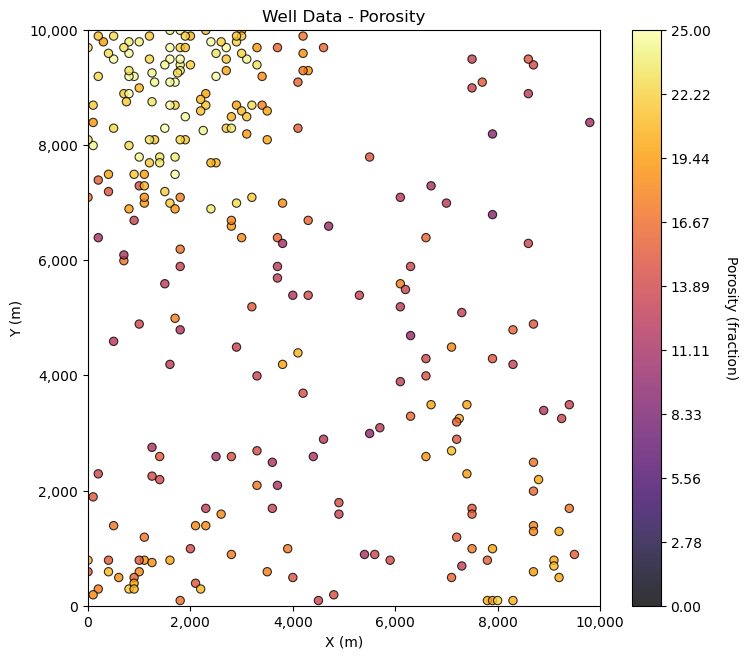

In [3]:
GSLIB.locmap_st(por_sample,'X','Y','Por',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X (m)','Y (m)','Porosity (fraction)',cmap)
plt.gca().xaxis.set_major_formatter(formatter); plt.gca().yaxis.set_major_formatter(formatter)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

For bootstrap we draw $n$ samples with replacement from this dataset.

* Here's 4 bootstrapped realizations.

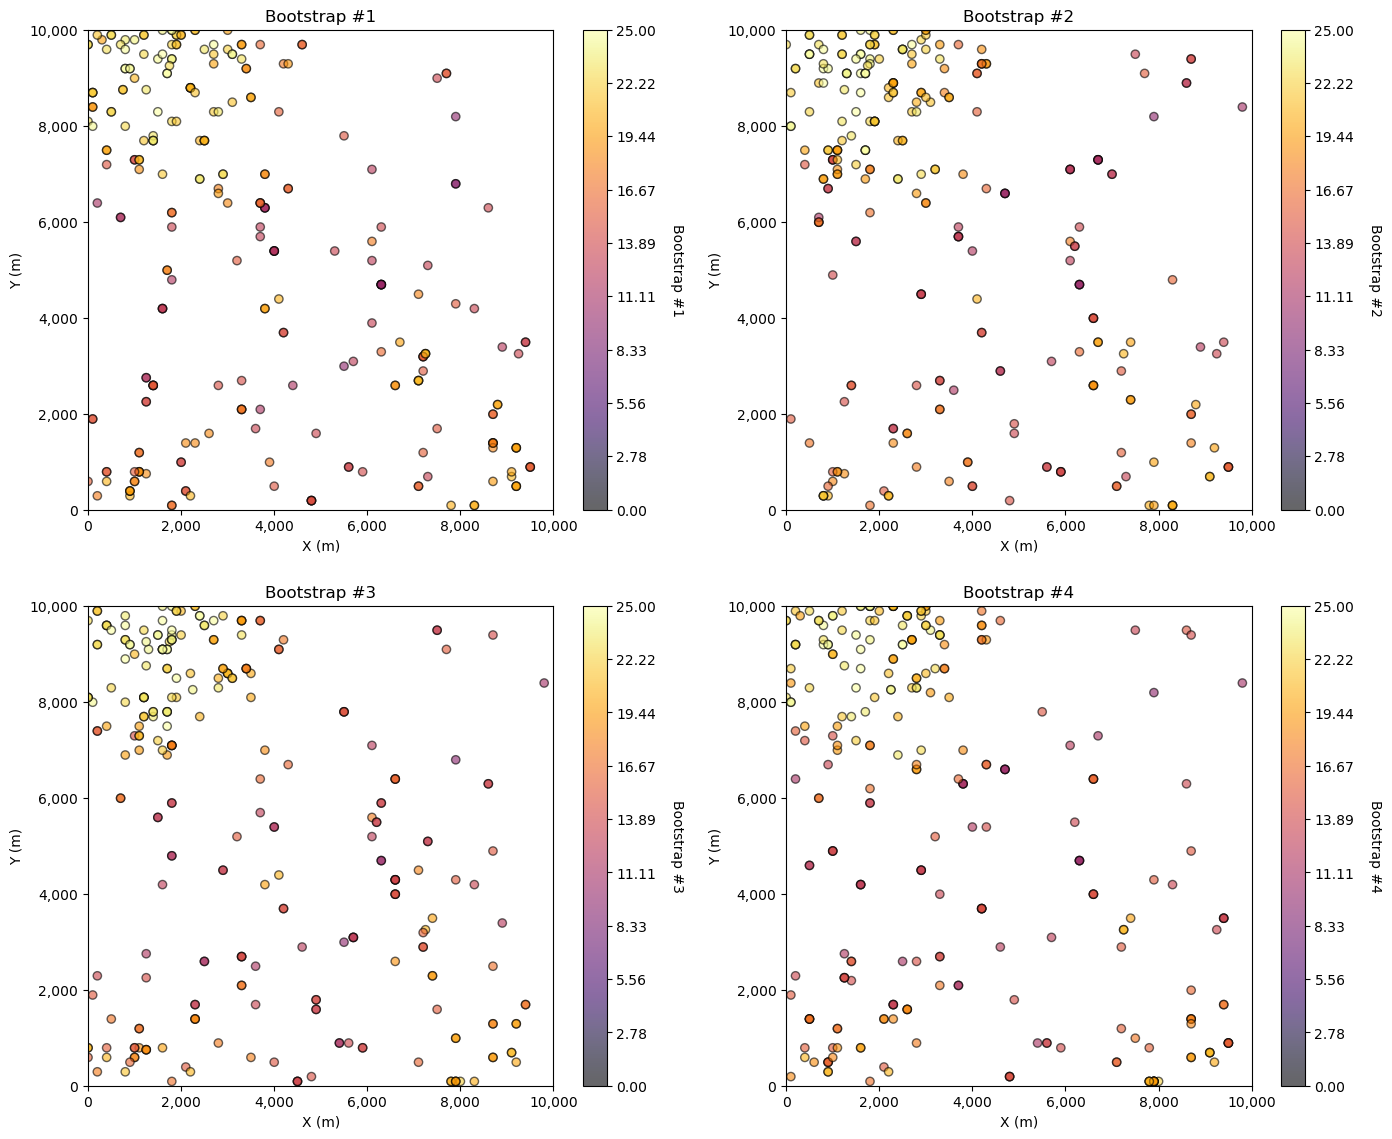

In [4]:
for l in range(0,L):
    por_real = por_sample.sample(n=len(por_sample), replace=True)

    sample_counts = por_real.groupby(['X', 'Y']).size().reset_index(name='Count')
    df_unique = por_real.drop_duplicates(subset=['X', 'Y']).reset_index(drop=True)
    
    plt.subplot(2,2,l+1)
    sc = plt.scatter(por_real['X'],por_real['Y'],c=por_real['Por'],edgecolor='black',vmin=pormin,vmax=pormax,alpha=0.6,cmap=cmap)
    plt.gca().xaxis.set_major_formatter(formatter); plt.gca().yaxis.set_major_formatter(formatter)
    plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Bootstrap #' + str(l+1)); plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc, orientation="vertical", ticks=np.linspace(pormin, pormax, 10))
    cbar.set_label('Bootstrap #' + str(l+1), rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.2); plt.show()

#### Bootstrap Steps 

These are the general steps for bootstrap,

1. assemble a sample set, must be representative, reasonable to assume independence between samples

<figure style="text-align: center;">
  <img src="_static/bootstrap/bootstrap_data.png" style="display: block; margin: 0 auto; width: 40%;">
  <figcaption style="text-align: center;"> Compile the data into a histogram.
</figcaption>
</figure>

2. optional: build a cumulative distribution function (CDF)
    * may account for declustering weights, tail extrapolation
    * could use analogous data to support

<figure style="text-align: center;">
  <img src="_static/bootstrap/bootstrap_cdf.png" style="display: block; margin: 0 auto; width: 40%;">
  <figcaption style="text-align: center;"> Compile the data into a histogram and convert to a CDF.
</figcaption>
</figure>

3. For $i = \alpha, \ldots, n$ data, do the following, draw a random sample with replacement from the sample set or Monte Carlo simulate from the CDF (if available). 

4. Calculate a realization of the summary statistic of interest from the $n$ samples, e.g. $m^\ell$, $\sigma^2_{\ell}$. 

<figure style="text-align: center;">
  <img src="_static/bootstrap/bootstrap_1.png" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Calculate a realization of the statistic of interest from the data realization.
</figcaption>
</figure>

5. For $\ell = 1, \ldots, L$ realizations, repeat steps 3 and 4 to calculate realizations of the sample statistic.

6. Compile and summarize the $L$ realizations of the statistic of interest.

<figure style="text-align: center;">
  <img src="_static/bootstrap/bootstrap_many.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;"> Pool $L$ realizations of the statistic to calculate the entire distribution of uncertainty.
</figcaption>
</figure>

#### Bootstrap 

Here's some additional comments about the bootstrap approach developed by Efron (1982),

* **Does this work?** - it does sound counter-intuitive, right? Uncertainty in the statistic from the data itself! Prove it to yourself, compare your bootstrap uncertainty in the mean with the solution by standard error,

$$
\sigma^2_\overline{x} = \frac{\sigma^2_s}{n}
$$

* **Extremely versatile** - could calculate uncertainty in any statistic! For example, P13, skew, fourth centered moment, Dykstra Parsons coefficient, etc.
  
* Would not be possible access general uncertainty in any statistic without bootstrap, but remember to not stop early. Get the realization of the data and finish calculating the realization of the statistic, e.g., for Dykstra-Parsons coefficient, calculate the realization of the $k_{50}$ and $k_{16}$ from the same data realization to get uncertainty in Dystra-Parsons coefficient. Do not calculate the uncertainty in the $k_{50}$ and $k_{16}$ separately! 
  
* Advanced forms account for spatial information and sampling strategy, e.g., game theory and Journel’s spatial bootstrap (1993).

This is a very powerful method. Let's try it out!

#### Load the Required Libraries

The following code loads the required libraries. 

In [5]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilizes, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


#### Check Another Package

At some point you are going to run into an issue with package versions. This is how you can check packages.

In [6]:
import numpy
numpy.__version__

'1.23.3'

We will also need some standard packages. These should have been installed with Anaconda 3.

In [7]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from scipy import stats                                       # summary statistics
import math                                                   # trig etc.
import scipy.signal as signal                                 # kernel for moving window calculation
import random
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs. 

#### Declare Functions

These are some of the functions from GeostatsPy required by the new program.  We will declare them here and then in the future integrate the new indicator kriging program into the package properly.

In [8]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [9]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [10]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load our data form my GitHub account

Let's drop some samples so that we increase the variations in bootstrap samples for our demonstration below.

* Warning, this is not a standard part of the bootstrap workflow, I'm doing this so my students can change the number of data and observe the impact on uncertainty.

In [11]:
df = df.sample(frac = 0.2)                                    # extract 50 random samples to reduce the size of the dataset  
print('Using ' + str(len(df)) + ' number of samples')

Using 58 number of samples


Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [12]:
df.head(n=3)                                                  # DataFrame preview to check

,X,Y,Facies,Porosity,Perm
239,550,979,1,0.152277,71.454424
68,640,529,1,0.120547,10.801778
78,290,149,1,0.159123,33.388219


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 0 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [13]:
df.describe().transpose()                                     # summary statistics

,count,mean,std,min,25%,50%,75%,max
X,58.0,507.413793,247.617138,0.000000,320.000000,490.000000,697.500000,990.000000
Y,58.0,506.482759,289.111964,9.000000,300.000000,509.500000,679.000000,979.000000
Facies,58.0,0.724138,0.450851,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,58.0,0.130742,0.039020,0.074349,0.100419,0.121756,0.143301,0.223661
Perm,58.0,217.950476,534.690105,0.089169,3.253038,11.450569,41.492085,2372.383732


#### Visualizing Tabular Data with Location Maps 

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [14]:
xmin = 0.0; xmax = 1000.0                                     # range of x values
ymin = 0.0; ymax = 1000.0                                     # range of y values
pormin = 0.05; pormax = 0.25;                                 # range of porosity values
nx = 100; ny = 100; csize = 10.0                       

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [15]:
GSLIB.locmap                                                  # GeostatsPy's 2D point plot function

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

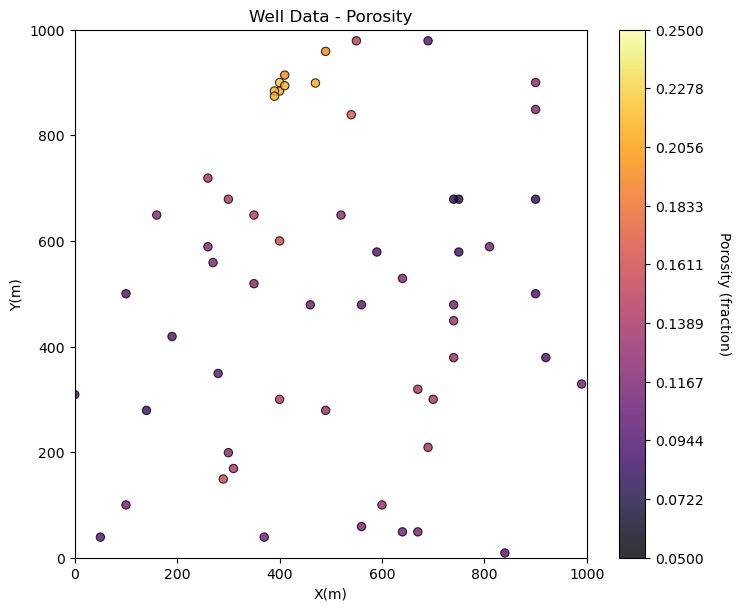

In [16]:
plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Simple Bootstrap Method in Python                       

If you are new to bootstrap and Python, here's the most simple code possible for bootstrap.

* specify the number of bootstrap realizations, $L$
* declare a list to store the bootstrap realizations of the statistic of interest
* loop over L bootstrap realizations
    * n MCS, random samples with replacement for a new realization of the data
    * calculate the realization of the statistic from the realization of the data
* summarize the resulting uncertainty model, histogram, summary statistics etc.

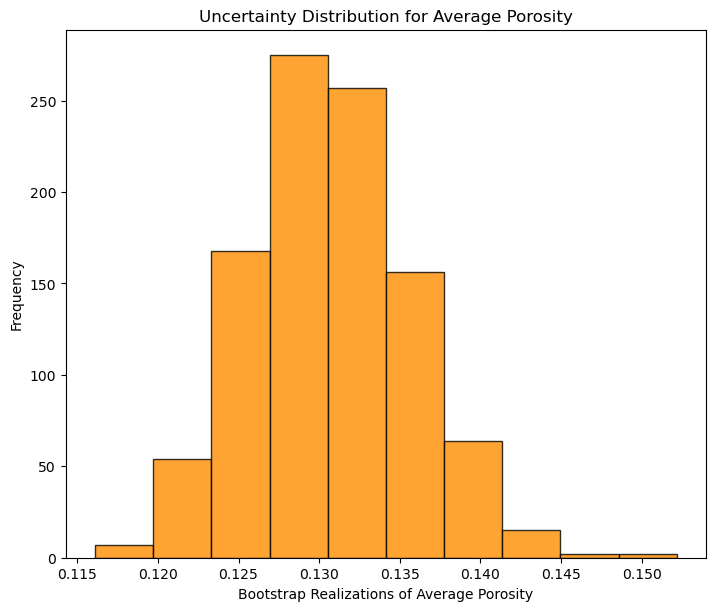

In [17]:
import random                          # import random package
L = 1000                               # set the number of bootstrap realizations   
por_avg_real = []                      # declare an empty list to store the bootstrap realizations of the statistic 
for k in range(0,L):                   # loop over the L bootstrap realizations
    samples = random.choices(df['Porosity'].values, k=len(df)) # n Monte Carlo simulations
    por_avg_real.append(np.average(samples)) # calculate the statistic of interest from the new bootstrap dataset
plt.hist(por_avg_real,color = 'darkorange',alpha = 0.8,edgecolor = 'black') # plot the distribution, could also calculate any summary statistics
plt.xlabel('Bootstrap Realizations of Average Porosity'); plt.ylabel('Frequency'); plt.title('Uncertainty Distribution for Average Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Now we proceed with a more complicated, robust work by first quantifying the spatial bias in the samples and assigned data weights to mitigate this bias.

#### Declustering

Let's calculate some declustering weights. There is a demonstration on declustering here https://git.io/fhgJl if you need more information. 

In [18]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts'] = wts                            # add weights to the sample data DataFrame
df.head()                                  # preview to check the sample data DataFrame

def weighted_avg_and_std(values, weights): # function to calculate weighted mean and st. dev., from Eric O Lebigot, stack overflow,
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

sample_avg, sample_stdev = weighted_avg_and_std(df['Porosity'],df['Wts'])
print('Declustered mean = ' + str(round(sample_avg,3)) + ' and declustered standard deviation = ' + str(round(sample_stdev,3)))

There are 58 data with:
   mean of      0.13074219132758622 
   min and max  0.074348923 and 0.223660709
   standard dev 0.0386818708755029 
Declustered mean = 0.119 and declustered standard deviation = 0.03


##### A Couple of Bootstrap Realizations

We will attempt bootstrap by-hand and manually loop over $L$ realizations and draw $n$ samples to calculate the summary statistics of interest, mean and variance. The choice function from the random package simplifies sampling with replacement from a set of samples with weights.

This command returns a ndarray with k samples with replacement from the 'Porosity' column of our DataFrame (df) accounting for the data weights in column 'Wts'.
```p
samples1 = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
```

It is instructive to look at a couple of these realizations from the original declustered data set.

Bootstrap means, realization 1 = 0.1271272426724138 and realization 2 = 0.1238174486551724


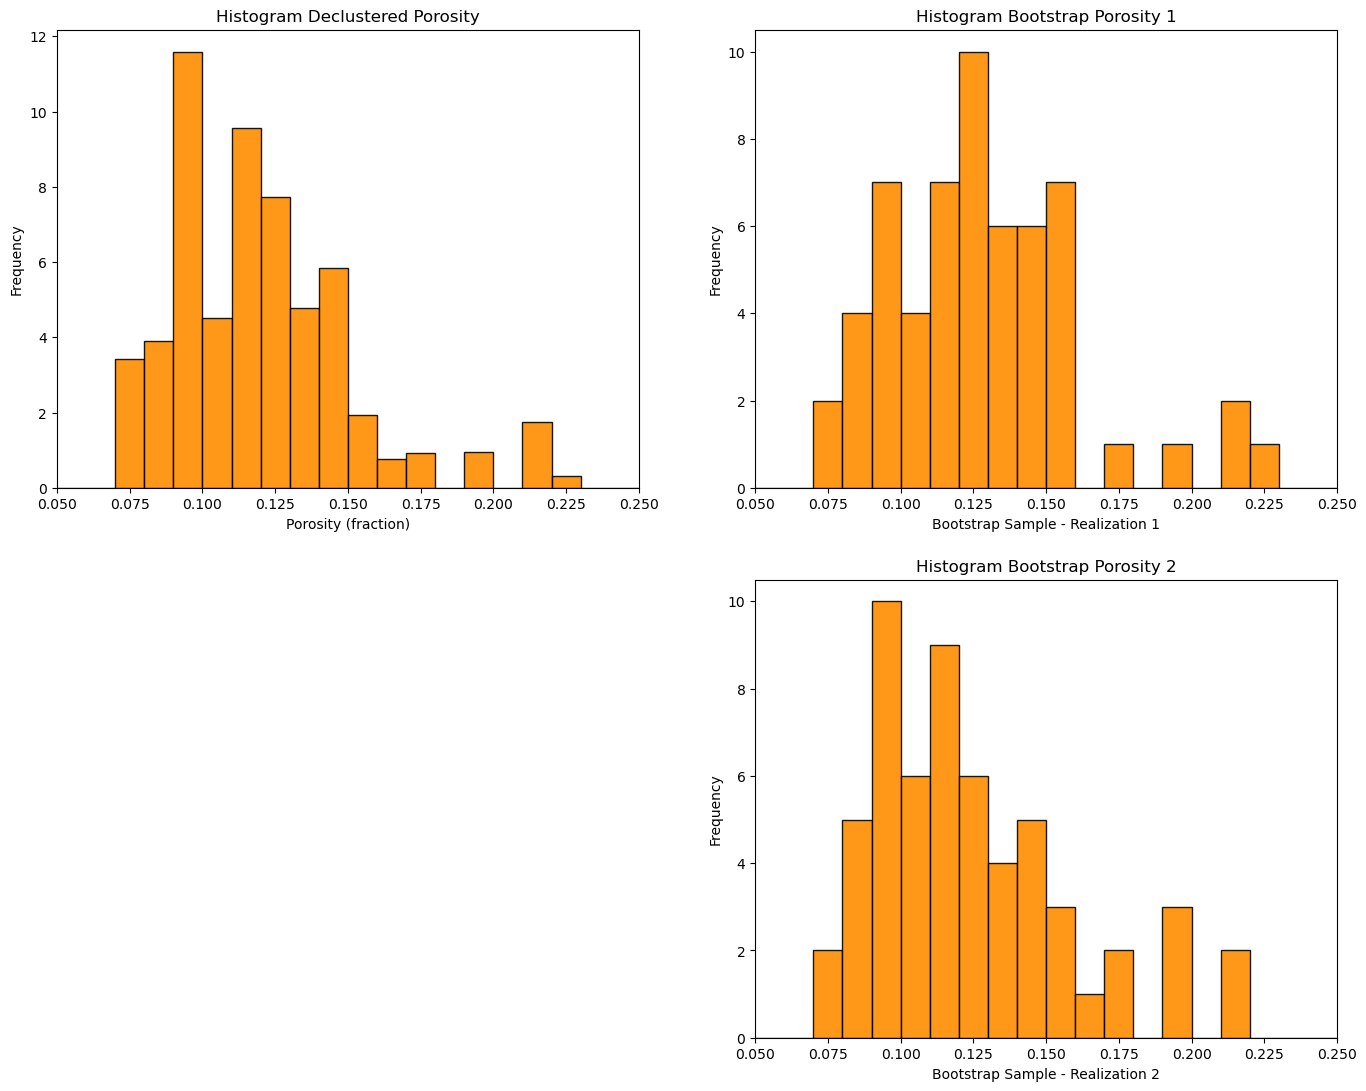

In [19]:
samples1 = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
samples2 = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))

print('Bootstrap means, realization 1 = ' + str(np.average(samples1)) + ' and realization 2 = ' + str(np.average(samples2)))

plt.subplot(221)
GSLIB.hist_st(df['Porosity'],pormin,pormax,False,False,20,df['Wts'],'Porosity (fraction)','Histogram Declustered Porosity')

plt.subplot(222)
GSLIB.hist_st(samples1,pormin,pormax,False,False,20,None,'Bootstrap Sample - Realization 1','Histogram Bootstrap Porosity 1')

plt.subplot(224)
GSLIB.hist_st(samples2,pormin,pormax,False,False,20,None,'Bootstrap Sample - Realization 2','Histogram Bootstrap Porosity 2')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

Note that the bootstrap distributions vary quite a bit from the original.

#### Summarizations Over Bootstrap Realizations

Let's make a loop to conduct $L$ resamples and calculate the average and standard deviation for each  ($m^\ell$, $\sigma^2_{\ell}$,  for $\ell = 0,\dots,L-1$). We then summarization over these $L$ realizations.  

I did not find any built-in, concise functions to accomplish this, i.e. with a single line of code, so we are going to do it by hand.  

To understand this code there are just a couple of Python concepts that you need to add to your Python arsenal.

1. declaring arrays - NumPy has a lot of great array (ndarray) functionality. There are build in functions to make a ndarray of any length (and dimension). This includes 'zeros', 'ones' and 'rand', so when we use this code (we're making arrays of length $L$ pre-populated with zeros):

```p
mean = np.zeros(L); stdev = np.zeros(L)
```

2. For Loops - when we are using the command below, we are instructing the computer to loop over all the indented code below the command for $l = 0,1,2,\ldots,L-1$ times. For each loop the $l$ variable increments, so we can use this to save each result to a different index in the arrays mean and stdev. Note, Python arrays index starting at 0 and stop at the length - 1 (we are running each bootstrap resampled realization, calculating the average and standard deviation and storing them in the arrays that we already declared).

```p
for l in range(0, L): 
```
Now, let's write the code for performing bootstrap and calculate the uncertainty in the mean and standard deviation.

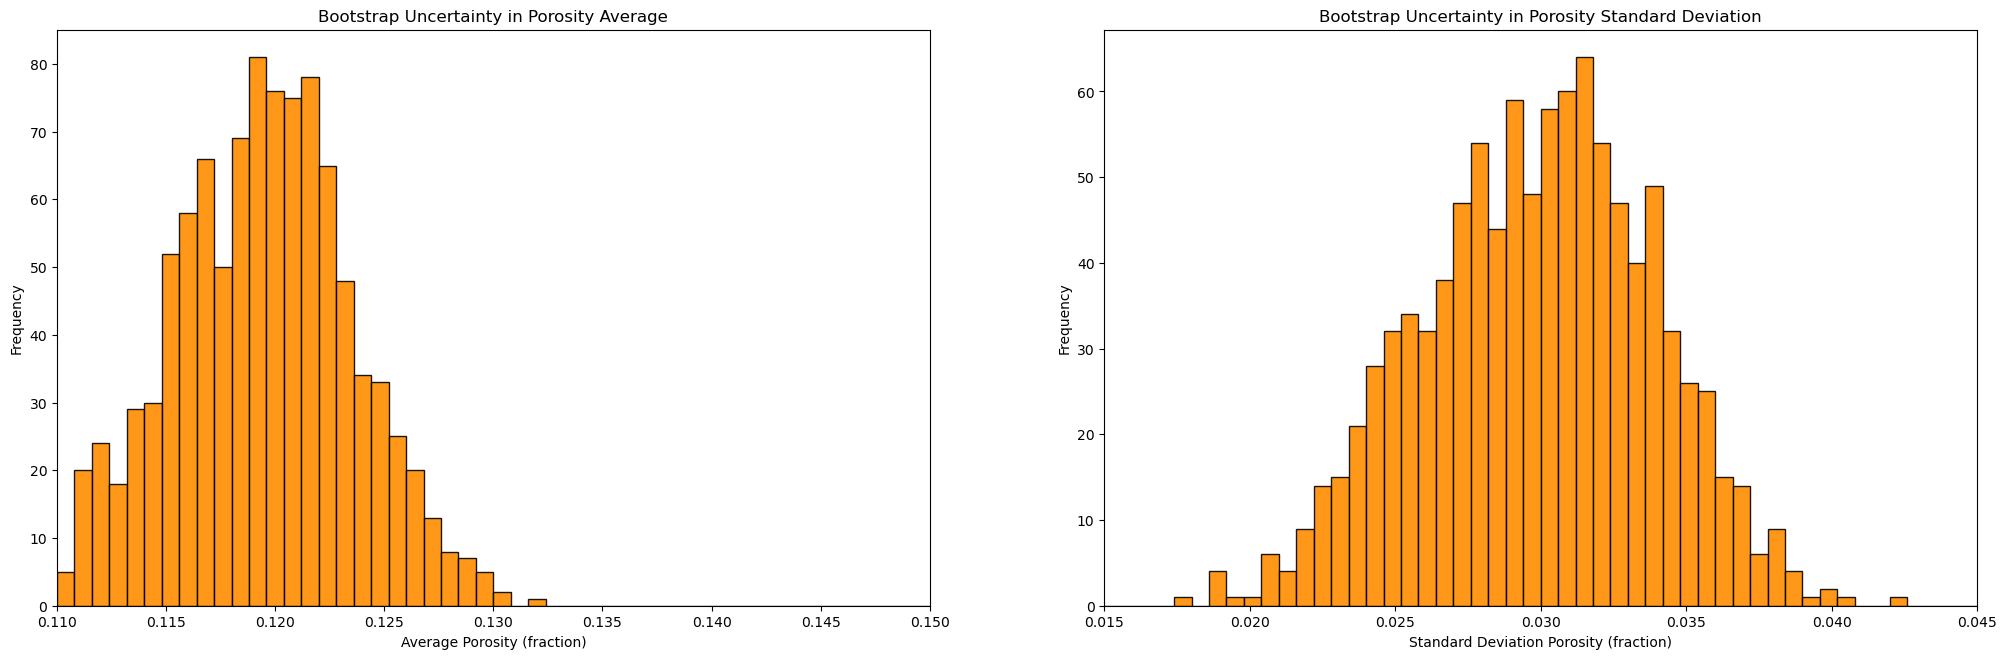

Summary Statistics for Bootstrap Porosity Mean Realizations:
DescribeResult(nobs=1000, minmax=(0.10878135187931036, 0.1322619299137931), mean=0.1193905127865, variance=1.6999560148896818e-05, skewness=0.004720621847868837, kurtosis=-0.2774077815068523)
P10: 0.114, P50: 0.12, P90: 0.125

Summary Statistics for Bootstrap Porosity Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(0.017676458232002566, 0.04207602686697348), mean=0.029864174006926193, variance=1.571991183137997e-05, skewness=-0.13097862810380806, kurtosis=-0.2958936650418962)
P10: 0.025, P50: 0.03, P90: 0.035


<Figure size 640x480 with 0 Axes>

In [20]:
L = 1000                                   # set the number of realizations
mean = np.zeros(L); stdev = np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
    mean[l] = np.average(samples)
    stdev[l] = np.std(samples)
    
plt.subplot(121)
GSLIB.hist_st(mean,0.11,0.15,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average')

plt.subplot(122)
GSLIB.hist_st(stdev,0.015,0.045,False,False,50,None,'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Porosity Mean Realizations:')
print(stats.describe(mean))
print('P10: ' + str(round(np.percentile(mean,10),3)) + ', P50: ' + str(round(np.percentile(mean,50),3)) + ', P90: ' + str(round(np.percentile(mean,90),3))) 

print('\nSummary Statistics for Bootstrap Porosity Standard Deviation Realizations:')
print(stats.describe(stdev))
print('P10: ' + str(round(np.percentile(stdev,10),3)) + ', P50: ' + str(round(np.percentile(stdev,50),3)) + ', P90: ' + str(round(np.percentile(stdev,90),3)))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Bootstrap in GeostatsPy

We have a simple bootstrap function in GeostatsPy

```python
realizations_array = geostats.bootstrap(array,stat,weights=None,nreal=100)
```

where:
    
* array - an numpy ndarray of samples
* stat - statistic function that can be applied to an ndarray, e.g., numpy.average
* weights - an array of weights, if omitted or set to None, then equal weighting is applied
* nreal - the number of realizations

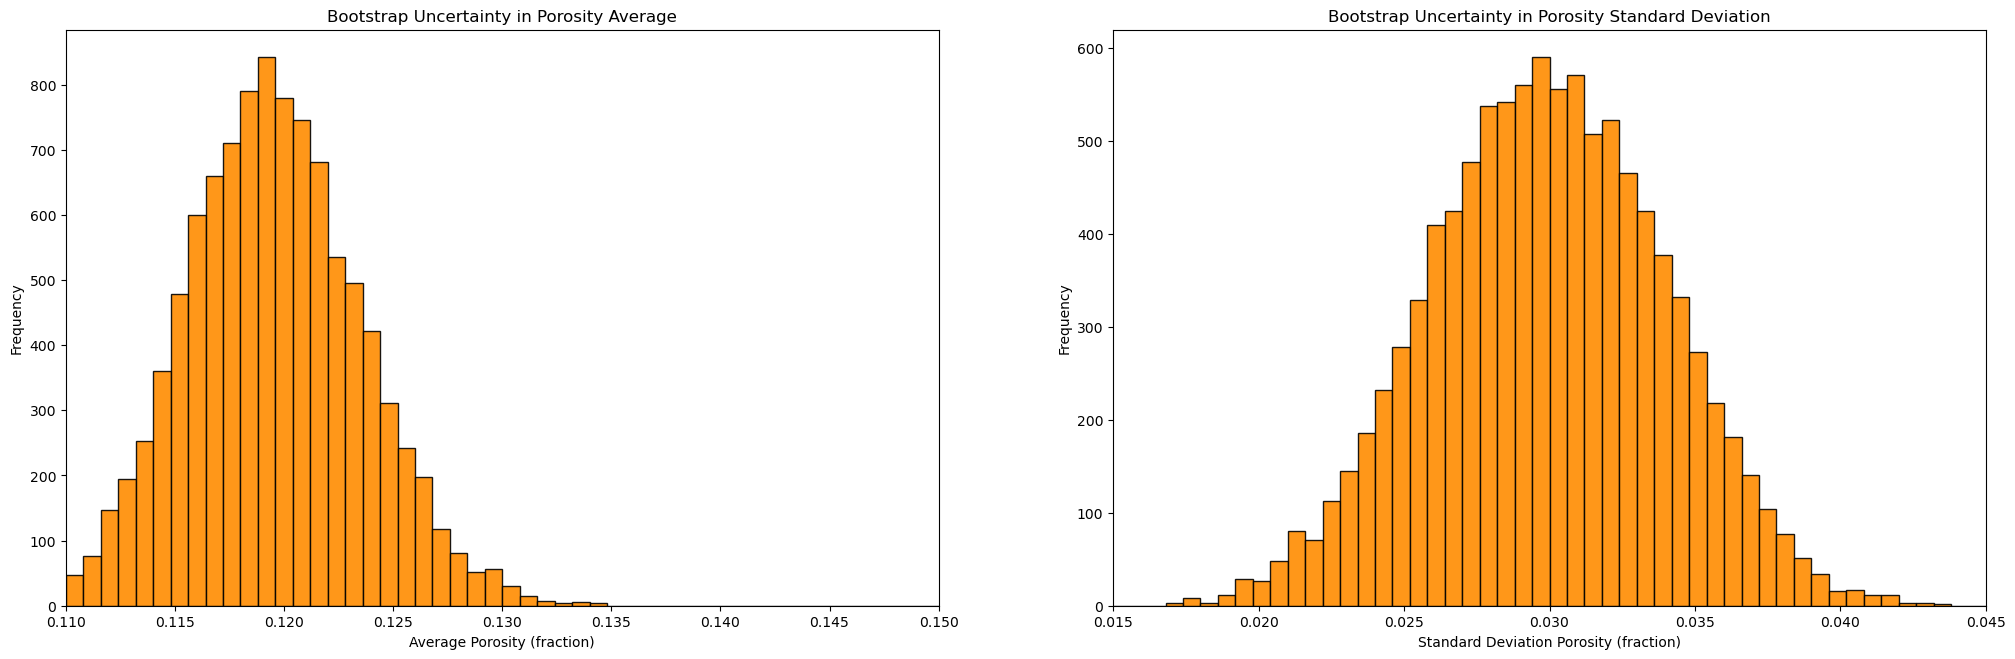

Summary Statistics for Bootstrap Porosity Mean Realizations:
DescribeResult(nobs=10000, minmax=(0.1052981649137931, 0.13452167096551723), mean=0.11951250730598104, variance=1.594763432053366e-05, skewness=0.16171120395175215, kurtosis=0.06360076434094841)
P10: 0.115, P50: 0.119, P90: 0.125

Summary Statistics for Bootstrap Porosity Standard Deviation Realizations:
DescribeResult(nobs=10000, minmax=(0.016910741695844198, 0.04546921629218046), mean=0.029901259598589063, variance=1.6233354373565006e-05, skewness=-0.008752870548468813, kurtosis=-0.17262519710499502)
P10: 0.025, P50: 0.03, P90: 0.035


<Figure size 640x480 with 0 Axes>

In [21]:
L = 10000
mean = geostats.bootstrap(df['Porosity'].values,stat = np.average,weights = df['Wts'].values,nreal = L)
stdev = geostats.bootstrap(df['Porosity'].values,stat = np.std,weights = df['Wts'].values,nreal = L)

plt.subplot(121)
GSLIB.hist_st(mean,0.11,0.15,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average')

plt.subplot(122)
GSLIB.hist_st(stdev,0.015,0.045,False,False,50,None,'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Porosity Mean Realizations:')
print(stats.describe(mean))
print('P10: ' + str(round(np.percentile(mean,10),3)) + ', P50: ' + str(round(np.percentile(mean,50),3)) + ', P90: ' + str(round(np.percentile(mean,90),3))) 

print('\nSummary Statistics for Bootstrap Porosity Standard Deviation Realizations:')
print(stats.describe(stdev))
print('P10: ' + str(round(np.percentile(stdev,10),3)) + ', P50: ' + str(round(np.percentile(stdev,50),3)) + ', P90: ' + str(round(np.percentile(stdev,90),3))) 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Comments

I hope you found this chapter helpful. Much more could be done and discussed, I have many more resources. Check out my [shared resource inventory](https://michaelpyrcz.com/my-resources),

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  